## **Automatically aligning Text files using Facebook Laser embeddings and cosine similarity.**



1.  **Facebook Laser Embeddings installation instructions:**

*   https://github.com/facebookresearch/LASER/blob/main/tasks/embed/README.md
*   For this notebook the Facebook models are saved on my onedrive, referenced a lot on the notebook


2.   The notebook was designed to work for the cabinet speeches json files. Hoever, if any new files are available and neeed to be aligned, the get_embeddings and align_files functions can be used. 

3. Source and target language are defined to determine the embedding mdoels to use. 

4. The output of this notebook is csv files stored on my google drive. The sample outout of the csv file is shown below. For each set of each set of files, a csv file with the cosine score is outputed. 

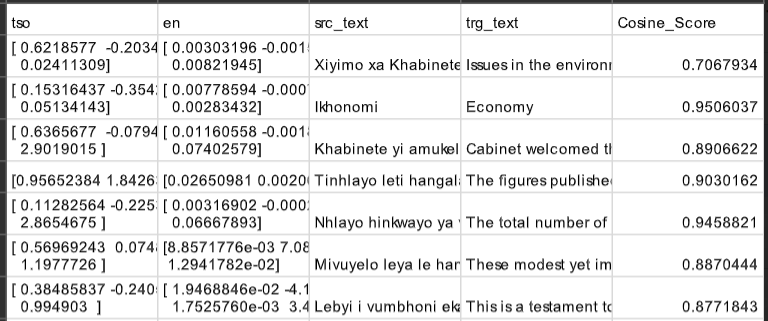




# Step 1: Install models and all neccesary files



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import pandas as pd
import re
import numpy as np
import csv

In [3]:
from nltk import tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import os
os.environ["gdrive_path"] = "/content/drive/My Drive/LASER"

**Install additional files and libraries**

In [5]:
!bash /content/drive/MyDrive/LASER/install_external_tools.sh

Installing external tools

automatic installation of the Japanese tokenizer mecab may be tricky
Please install it manually from https://github.com/taku910/mecab

The installation directory should be /content/drive/MyDrive/LASER/tools-external/mecab



In [6]:
#!bash /content/drive/MyDrive/LASER/install_models.sh

***Install Only needed models***

Available models for different languages are defined here -- [link text](https://github.com/facebookresearch/LASER/blob/main/nllb/README.md)

In [7]:
!bash /content/drive/MyDrive/LASER/nllb/download_models.sh tso_Latn	eng_Latn xho_Latn zul_Latn tsn_Latn ssw_Latn sot_Latn

Directory for model download: /content/models
 - creating model directory: /content/models
 - https://dl.fbaipublicfiles.com/nllb/laser/laser2.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser2.spm
 - https://dl.fbaipublicfiles.com/nllb/laser/laser2.cvocab
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-tso_Latn.v1.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-eng_Latn.v1.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-xho_Latn.v1.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-zul_Latn.v1.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-tsn_Latn.v1.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-ssw_Latn.v1.pt
 - https://dl.fbaipublicfiles.com/nllb/laser/laser3-sot_Latn.v1.pt


# Set LASER variable and install any modules

In [8]:
os.environ["LASER"] = "/content/drive/MyDrive/LASER"

In [9]:
!pip install transliterate
!pip install fairseq==0.12.1
!pip install tabulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 KB 2.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.4/240.4 KB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 KB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141231 sha256=1a88b039c9b89639d9330b9ccaad683bae310f5c405f47fdda9fa7722444d4c8
  Stored in directory: /root/.cache/pip/wheels/c8/d0/ab/d43c02eaddc5b9004db86950802442ad9a26f27

# Get the cabinet speeches

In [10]:
speeches_data = pd.read_json('/content/drive/MyDrive/govza-cabinet-statements_new.json')

***EDA on the speeches***

In [11]:
speeches_data.info()
speeches_data['date'].is_unique
len(pd.unique(speeches_data['date']))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype                                
---  ------    --------------  -----                                
 0   title     158 non-null    object                               
 1   url       158 non-null    object                               
 2   date      158 non-null    datetime64[ns]                       
 3   datetime  158 non-null    datetime64[ns, pytz.FixedOffset(120)]
 4   en        158 non-null    object                               
 5   af        158 non-null    object                               
 6   nr        158 non-null    object                               
 7   xh        158 non-null    object                               
 8   zu        158 non-null    object                               
 9   st        158 non-null    object                               
 10  nso       158 non-null    object                              

158

***Add datekey columns and rename Xitsonga column***

In [12]:
#create new column with the date - replaced by _
speeches_data['date_key'] = speeches_data['date'].astype(str).str.replace('-','_')
speeches_data.rename(columns={'ts last':'tso'}, inplace=True)

In [13]:
speeches_data.head(2)

,title,url,date,datetime,en,af,nr,xh,zu,st,nso,ss,ve,tso,date_key
0,Statement on the virtual Cabinet Meeting of 31...,https://www.gov.za/speeches/statement-virtual-...,2022-09-01,2022-09-01 00:00:00+02:00,{'text': 'A. Issues in the environment#n#1. ...,{'text': 'A. Kwessies in die Omgewing#n#1. ...,{'text': 'A. Ezingundabamlonyeni #n#1. Z...,{'text': 'A. Imiba enguNdaba-mlonyeni#n#1. ...,{'text': 'A. Ezisematheni#n#1. Umnotho #...,{'text': 'A. Maemo a Renang ha Jwale1. Moruo1....,{'text': 'A. Ditaba tše di Amago Badudi1. Ekon...,{'text': 'A. Tindzaba Letibalulekile telive...,{'text': '1. Ikonomi1.1. Khabinethe yo ṱangane...,{'text': 'A. Xiyimo xa Khabinete eka Timhak...,2022_09_01
1,Statement on the virtual Cabinet Meeting of 17...,https://www.gov.za/speeches/statement-virtual-...,2022-08-13,2022-08-13 00:00:00+02:00,{'text': 'Issues in the Environment#n#1. Energ...,{'text': 'A. Kwessies in die omgewing #n#1. Kr...,{'text': 'A. Ezingundabamlonyeni#n#1. Zegezi #...,{'text': 'Issues in the Environment#n#1. Energ...,{'text': 'A. Ezisematheni#n#1. Ezamandla #n#1....,{'text': 'A. Maemo a Renang ha Jwale#n#1. Mo...,{'text': 'A. Ditaba tšeo di Amago Badudi1. ...,{'text': 'A. Tindzaba Letibalulekile Telive#n...,{'text': 'A. Mafhungo a Zwino kha Shango#n#1....,{'text': 'A. Xiyimo xa Khabinete eka Timhakaku...,2022_08_13


***Create Language and LASER models mappings***

In [14]:
#create language mappings 
languages = {'en' : '','af' : '','nr': '','xh':'xho_Latn','zu':'zul_Latn','st':'tsn_Latn','nso':'','ss':'ssw_Latn','ve':'','ts':'sot_Latn','tso':'tso_Latn'}

# **Create Functions**

***This function aligns two given sentence emneddings files. The similarity score is calculated and the max similarity is consider. Eliminated repeating target mappings.***

In [15]:
def align_files(source_file, target_file,source_lang,target_lang,f,g,date_key):

#Create Paths to use to output the aligned files to
    path = '/content/drive/MyDrive/LASER/data/tso_eng_aligned/'
    path_csv = '/content/drive/MyDrive/LASER/data/tso_eng_aligned_csv/'
    
    used_sentences =[]  #This is used keep record of indexes used as target sentences
    df = pd.DataFrame(columns = [source_lang,target_lang,"src_text","trg_text", "Cosine_Score"])
    loop_iter = min([len(source_file),len(target_file),len(f), len(g)])
    
    for i in range(loop_iter): #range(len(source_file)):
      similarity_array = {}

      for j in range(loop_iter): #range(len(target_file)):
        if j in used_sentences:
          continue #skip j index that has been used
        else:
            source_sent = source_file[i]
            targt_sent = target_file[j]
            #Calculate the similarity between sentences
            sim_score=cosine_similarity(source_sent.reshape(1,-1),targt_sent.reshape(1,-1))
            similarity_array[j] = sim_score[0][0]
      
      max_similar = max(similarity_array, key = similarity_array.get,default=0)
      used_sentences.append(max_similar)
      #Create dataframe to store sentences
      df = df.append({source_lang: source_file[i],target_lang: target_file[max_similar],'src_text': f['text'][i],'trg_text':g['text'][max_similar],'Cosine_Score':similarity_array[max_similar]},ignore_index=True)
      
    #Output full dataframe to a csv file
    out_put_file = date_key +"_" + source_lang + "_" + target_lang
    df.to_csv(path_csv + out_put_file + ".csv", sep=',', index=False)

    df['src_text'].to_csv(path + date_key +"_" + source_lang + '_aligned' +'.txt', header=None, index=None, sep='\t', mode='a')
    df['trg_text'].to_csv(path + date_key +"_" + target_lang + '_aligned' +'.txt', header=None, index=None, sep='\t', mode='a')

    return df

In [16]:
def get_embeddings(f,g,source_embeddings,target_embeddings,source_model,target_model):

    !bash /content/drive/MyDrive/LASER/tasks/embed/embed.sh $f.name $source_embeddings   $source_model

    !bash /content/drive/MyDrive/LASER/tasks/embed/embed.sh $g.name $target_embeddings   $target_model

    #print(target_embeddings,file=s)
    k=!realpath $source_embeddings
    y=!realpath $target_embeddings
    dim = 1024
    source_file_arr = np.fromfile(k[0], dtype=np.float32, count=-1)                                                                          
    source_file_arr.resize(source_file_arr.shape[0] // dim, dim)  

    target_file_arr = np.fromfile(y[0], dtype=np.float32, count=-1)                                                                          
    target_file_arr.resize(target_file_arr.shape[0] // dim, dim)  

    return source_file_arr,target_file_arr

*This function pre-processes the json text, removed any unwanted characters and numbering*

In [17]:
def pre_process_text(text):
  text = re.sub("(\;[a-z]\.)","",text) #Replace ;a. with nothing
  text = re.sub('\d\.\d.',"",text) #Replace Numbers e.g. 2.2. with nothing
  #text = re.sub('^\d.',"",text) #Replace Numbers e.g. 2.2. with nothing
  text = re.sub('\.\d.',"",text)   #Replace .1. with nothing
  text = re.sub('[A-Za-z]\.',"",text) #Replace A. with nothing
  text = re.sub('^\.', "",text)  #Remove any dots starting a line
  #text = re.sub('#n#', '',text)
  text = re.sub('^\b\d\b.+',"",text) #Remove a single digit starting a line e.g. 7.

  #text = text.replace(";",".")
  return text

**This function splits more than 2 white spaces into new lines as well as split the HTML br tag that has been replaced by #n#**





---

In [18]:
def split_sences_character(input_text):
  output_array = []
  text = tokenize.sent_tokenize(pre_process_text(input_text))
  for s in text:
    text = re.split('\s{2,}',s) #Finds 2 or more white spaces
    for j in text:
      text =re.split('#n#',j)
      for k in text:
        output_array.append(k)

  return output_array

In [19]:
def split_sences_spaces(input_text):
  output_array = []
  text = tokenize.sent_tokenize(pre_process_text(input_text))
  for s in text:
    text = re.split('\s{2,}',s) #Finds 2 or more white spaces
    for j in text:
      text =re.split('#n#',j)
      for k in text:
        output_array.append(k)

  return output_array

# **Now create embeddings and align the files**

In [ ]:
#Define source and target languages
source_lang ='tso'  
target_lang = 'en'

#Get corresponding models for the languages
source_model = languages[source_lang]
target_model = languages[target_lang]

for i in  range(0,len(speeches_data)): # test: range(10): #
    print("Execution",i)
    dict_src = speeches_data[source_lang][i]
    dict_targ = speeches_data[target_lang][i]
    src_file = source_lang+ "_" + speeches_data['date_key'][i]
    trg_file = target_lang+ "_" + speeches_data['date_key'][i]

    src_sentences = split_sences_spaces(dict_src.get('text'))
    trg_sentences = split_sences_spaces(dict_targ.get('text'))

    # Read in the file
    with open("/content/sample_data/%s.txt"%src_file,'w') as f:
      #f.write(dict_src.get('text'))
      for item in src_sentences:
        if item.strip() and len(item) > 3:
          f.write((str(item)))
          f.write("\n")
    
    with open("%s.txt"%trg_file,'w') as g:
      #f.write(dict_src.get('text'))
      for item in trg_sentences:
        if item.strip() and len(item) > 3:
          g.write((str(item)))
          g.write("\n")

    source_embeddings = source_lang +'_' + speeches_data['date_key'][i] + "_" + 'emb'
    target_embeddings = target_lang +'_' + speeches_data['date_key'][i] + "_" + 'emb'

    src_data_frame = pd.read_csv(f.name,sep='\n',header=None,names=['text'])
    trg_data_frame = pd.read_csv(g.name,sep='\n',header=None,names=['text'])
    
    source_file_arr,target_file_arr = get_embeddings(f,g,source_embeddings,target_embeddings,source_model,target_model)
    
    date_key = speeches_data['date_key'][i]
    df = align_files(source_file_arr, target_file_arr,source_lang,target_lang,src_data_frame,trg_data_frame,date_key)


# **Create one big files with the aligned text files**

***Read all text files and store them in a file list***

In [21]:
import pandas as pd
import os

#txtfolder = r'/content/drive/MyDrive/LASER/data/tso_eng_aligned' #Change when loading different files

txtfolder = r'/content/drive/MyDrive/LASER/data/tso_eng_aligned_csv' #Change when loading different files


#Find the textfiles
textfiles = []
for root, folder, files in os.walk(txtfolder):
    for file in files:
        if file.endswith('.csv'):
            textfiles.append(file)

In [22]:
textfiles

['2021_11_25_tso_en.csv',
 '2021_11_04_tso_en.csv',
 '2021_09_30_tso_en.csv',
 '2021_09_20_tso_en.csv',
 '2021_09_02_tso_en.csv',
 '2021_08_19_tso_en.csv',
 '2021_08_05_tso_en.csv',
 '2021_07_01_tso_en.csv',
 '2021_06_10_tso_en.csv',
 '2021_05_27_tso_en.csv',
 '2021_05_13_tso_en.csv',
 '2021_04_22_tso_en.csv',
 '2021_03_25_tso_en.csv',
 '2021_03_11_tso_en.csv',
 '2021_02_26_tso_en.csv',
 '2020_12_04_tso_en.csv',
 '2020_11_19_tso_en.csv',
 '2020_11_05_tso_en.csv',
 '2020_10_22_tso_en.csv',
 '2020_09_24_tso_en.csv',
 '2020_09_09_tso_en.csv',
 '2020_08_27_tso_en.csv',
 '2020_08_06_tso_en.csv',
 '2020_06_26_tso_en.csv',
 '2020_06_11_tso_en.csv',
 '2020_06_04_tso_en.csv',
 '2020_05_28_tso_en.csv',
 '2020_04_15_tso_en.csv',
 '2020_03_12_tso_en.csv',
 '2020_02_18_tso_en.csv',
 '2019_12_17_tso_en.csv',
 '2019_11_21_tso_en.csv',
 '2019_10_31_tso_en.csv',
 '2019_10_17_tso_en.csv',
 '2019_09_19_tso_en.csv',
 '2019_09_06_tso_en.csv',
 '2019_08_22_tso_en.csv',
 '2019_08_08_tso_en.csv',
 '2019_07_25

***Create a data frame of the file names***

In [23]:
type(textfiles)
df = pd.DataFrame(textfiles, columns =['File_Name'])
df["language"] = ''

In [24]:
df_files = pd.concat((pd.read_csv(txtfolder + '/' + f) for f in textfiles), ignore_index=True)


In [25]:
df_files.loc[df_files['Cosine_Score'] > 0.7]

,tso,en,src_text,trg_text,Cosine_Score
0,[ 0.7145749 -0.07618906 -0.01454243 ... 0.17...,[ 0.00980162 -0.00337151 -0.00078007 ... 0.00...,Xiyimo xa Khabinete eka Timhakakulu1.,Issues in the environment1.,0.730768
2,[ 1.0462431 -0.03480151 0.20444773 ... 0.52...,[0.02621761 0.01854523 0.03063023 ... 0.013244...,Khabinete yi tsakile leswaku kutlula 260 000 w...,Vaccination against the Coronavirus Disease (C...,0.872722
3,[0.68304986 0.0632768 0.02563704 ... 0.476769...,[ 3.0232746e-02 -1.2357700e-04 -1.8443407e-05 ...,Hi boheka ku tsundzuka leswaku xitsongwatsongw...,We must remember that the virus has not been ...,0.880580
4,[ 0.45835593 -0.10967119 0.05802017 ... 1.10...,[ 2.1667289e-02 -1.4934938e-03 -1.4440740e-05 ...,Nsawutiso i mahala eka vanhu hinkwavo lava tsh...,Vaccination is free to all people living in S...,0.908174
5,[ 0.40109932 -0.13725062 -0.04675705 ... 0.23...,[ 0.01398541 -0.00204578 0.00195896 ... 0.01...,Modlolo wa Nhluvukiso wa Swifundzatsongo (DDM),Sectoral Emission Targets (SETs) Framework,0.737919
...,...,...,...,...,...
7546,[ 0.77740806 -0.06521156 -0.13596612 ... 1.21...,[ 7.5413482e-03 2.5712827e-03 -2.8479024e-05 ...,Mnn Nomonde Mnukwa tanihi DDG: Vukorhokeri bya...,Ms Nomonde Mnukwa as DDG: Corporate Services a...,0.822860
7547,[ 0.3799376 0.05228443 -0.15425166 ... 1.18...,[ 0.02337592 -0.00044798 -0.00023919 ... 0.02...,Ttn Nhlanhla Edgar Sishi tanihi DDG: Hofisi ya...,Mr Nhlanhla Edgar Sishi as DDG: Budget Office ...,0.854556
7548,[ 1.4601823 1.4300171 -0.35390761 ... 0.51...,[ 0.01752414 0.02866037 -0.00136389 ... 0.01...,Dkd Litha Magingxa tanihi Muofisirinkulu wa Vu...,Dr Litha Magingxa as Chief Executive Officer (...,0.913183
7550,[ 0.24439837 0.13670242 -0.31375104 ... 0.41...,[ 0.02789224 -0.00063916 0.00019392 ... 0.01...,Mnn Rofhiwa Irene Singo tanihi Muofisirinkulu ...,Ms Rofhiwa Irene Singo as Chief Financial Offi...,0.886381


In [26]:
df_files.loc[df_files['Cosine_Score'] > 0.7].src_text.to_csv(r'20221002_tso.txt', header=None, index=None, sep=' ')
df_files.loc[df_files['Cosine_Score'] > 0.7].trg_text.to_csv(r'20221002_eng.txt', header=None, index=None, sep=' ')


In [27]:
np.savetxt(r'20221002_tso.txt',df_files.loc[df_files['Cosine_Score'] > 0.7].src_text, fmt='%s')
np.savetxt(r'20221002_eng.txt',df_files.loc[df_files['Cosine_Score'] > 0.7].trg_text, fmt='%s')
